Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Strojno učenje 1 2021/2022
http://www.fer.unizg.hr/predmet/struce1

------------------------------

### Logistička regresija

*Verzija: 1.0 
Zadnji put ažurirano: 1. 10. 2021.*

(c) 2015-2021 Jan Šnajder, Domagoj Alagić  

Rok za predaju: **7. studenog 2021. u 23:59h**

------------------------------

### Upute

Ova laboratorijska vježba sastoji se od četiri zadatka. U nastavku slijedite upute navedene u ćelijama s tekstom. Rješavanje vježbe svodi se na **dopunjavanje ove bilježnice**: umetanja ćelije ili više njih **ispod** teksta zadatka, pisanja odgovarajućeg kôda te evaluiranja ćelija. 

Osigurajte da u potpunosti **razumijete** kôd koji ste napisali. Kod predaje vježbe, morate biti u stanju na zahtjev asistenta (ili demonstratora) preinačiti i ponovno evaluirati Vaš kôd. Nadalje, morate razumjeti teorijske osnove onoga što radite, u okvirima onoga što smo obradili na predavanju. Ispod nekih zadataka možete naći i pitanja koja služe kao smjernice za bolje razumijevanje gradiva (**nemojte pisati** odgovore na pitanja u bilježnicu). Stoga se nemojte ograničiti samo na to da riješite zadatak, nego slobodno eksperimentirajte. To upravo i jest svrha ovih vježbi.

Vježbe trebate raditi **samostalno**. Možete se konzultirati s drugima o načelnom načinu rješavanja, ali u konačnici morate sami odraditi vježbu. U protivnome vježba nema smisla.

In [1]:
# Učitaj osnovne biblioteke...
import sklearn
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [9]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        plt.figure(figsize=(12,6))
        # Create a mesh to plot in
        r = 0.04  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

### 1. Logistička regresija

Ovaj zadatak bavi se probabilističkim diskriminativnim modelom, **logističkom regresijom**, koja je, unatoč nazivu, klasifikacijski model.

Logistička regresija tipičan je predstavnik tzv. **poopćenih linearnih modela** koji su oblika: $h(\mathbf{x})=f(\mathbf{w}^\intercal\tilde{\mathbf{x}})$. Logistička funkcija za funkciju $f$ koristi tzv. **logističku** (sigmoidalnu) funkciju $\sigma (x) = \frac{1}{1 + \textit{exp}(-x)}$.

### (a)  

Definirajte logističku (sigmoidalnu) funkciju $\mathrm{sigm}(x)=\frac{1}{1+\exp(-\alpha x)}$ i prikažite je za $\alpha\in\{1,2,4\}$.

In [3]:
def sigm(x, a):
    return 1/(1 + exp(- a * x))

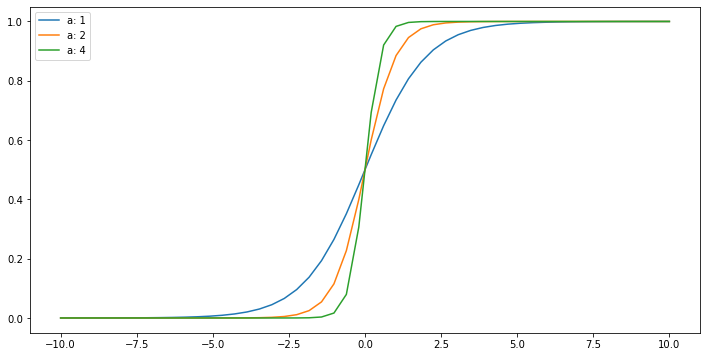

In [30]:
x = np.linspace(-10, 10)

plt.figure(figsize=(12, 6))
for a in [1, 2, 4]:
    label = 'a: ' + str(a)
    plt.plot(x, sigm(x, a), label=label)
    plt.legend()

**Q**: Zašto je sigmoidalna funkcija prikladan izbor za aktivacijsku funkciju poopćenoga linearnog modela? 
</br>

**Q**: Kakav utjecaj ima faktor $\alpha$ na oblik sigmoide? Što to znači za model logističke regresije (tj. kako izlaz modela ovisi o normi vektora težina $\mathbf{w}$)?

### (b) 

Implementirajte funkciju 

> `lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False)` 

za treniranje modela logističke regresije gradijentnim spustom (*batch* izvedba). Funkcija uzima označeni skup primjera za učenje (matrica primjera `X` i vektor oznaka `y`) te vraća $(n+1)$-dimenzijski vektor težina tipa `ndarray`. Ako je `trace=True`, funkcija dodatno vraća listu (ili matricu) vektora težina $\mathbf{w}^0,\mathbf{w}^1,\dots,\mathbf{w}^k$ generiranih kroz sve iteracije optimizacije, od 0 do $k$. Optimizaciju treba provoditi dok se ne dosegne `max_iter` iteracija, ili kada razlika u pogrešci unakrsne entropije između dviju iteracija padne ispod vrijednosti `epsilon`. Parametar `alpha` predstavlja faktor L2-regularizacije.

Preporučamo definiranje pomoćne funkcije `lr_h(x,w)` koja daje predikciju za primjer `x` uz zadane težine `w`. Također, preporučamo i funkciju `cross_entropy_error(X,y,w)` koja izračunava pogrešku unakrsne entropije modela na označenom skupu `(X,y)` uz te iste težine.

**NB:** Obratite pozornost na to da je način kako su definirane oznake ($\{+1,-1\}$ ili $\{1,0\}$) kompatibilan s izračunom funkcije gubitka u optimizacijskome algoritmu.

In [5]:
from numpy import linalg

def lr_train(X, y, eta=0.01, max_iter=2000, alpha=0, epsilon=0.0001, trace=False):
    weights = np.zeros(X.shape[1] + 1)
    wtrace = []
    
    for i in range(max_iter):
        deltaW = np.zeros(X.shape[1] + 1)
        dw0 = 0
        
        for j in range(X.shape[0]):
            h = lr_h(X[j], weights)
            dw0 = dw0 + h - y[j]
            tmp = np.append(1, X[j])
            deltaW = deltaW + (h - y[j]) * tmp
            
        w0 = weights[0]
        w0 = w0 - (eta * dw0)
        weights = (1 - alpha * eta) * weights - deltaW * eta
        weights[0] = w0
        wtrace.append(weights)
        
        error = cross_entropy_error(X, y, weights) + alpha * norm(weights)
        if  error < epsilon:
            break
            
    if trace: 
        return weights, wtrace
    return weights

In [6]:
def cross_entropy_error(X, y, w): 
    h = []
    for x in X:
        h.append(lr_h(x, w))
    loss = log_loss(y, h)
    return loss

In [7]:
from sklearn.metrics import log_loss

def lr_h(x, w): 
    append = np.append(1, x)
    dot = w.dot(append)
    return sigm(dot, 1)

### (c)

Koristeći funkciju `lr_train`, trenirajte model logističke regresije na skupu `seven`, prikažite dobivenu granicu između klasa te  izračunajte pogrešku unakrsne entropije. 

**NB:** Pripazite da modelu date dovoljan broj iteracija.

In [8]:
seven_X = np.array([[2,1], [2,3], [1,2], [3,2], [5,2], [5,4], [6,3]])
seven_y = np.array([1, 1, 1, 1, 0, 0, 0])

0.07751718252492557


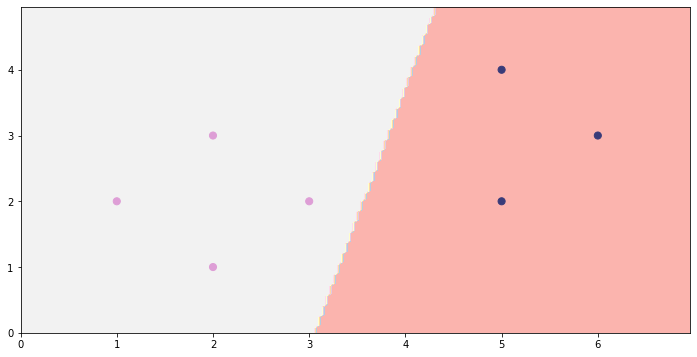

In [10]:
weights = lr_train(seven_X, seven_y)
print(cross_entropy_error(seven_X, seven_y, weights))
func = lambda x: lr_h(x, weights) >= 0.5
plot_2d_clf_problem(seven_X, seven_y, h=func)

**Q:** Koji kriterij zaustavljanja je aktiviran?

**Q:** Zašto dobivena pogreška unakrsne entropije nije jednaka nuli?

**Q:** Kako biste utvrdili da je optimizacijski postupak doista pronašao hipotezu koja minimizira pogrešku učenja? O čemu to ovisi?

**Q:** Na koji način biste preinačili kôd ako biste htjeli da se optimizacija izvodi stohastičkim gradijentnim spustom (*online learning*)?

### (d)

Prikažite na jednom grafikonu pogrešku unakrsne entropije (očekivanje logističkog gubitka) i pogrešku klasifikacije (očekivanje gubitka 0-1) na skupu `seven` kroz iteracije optimizacijskog postupka. Koristite trag težina funkcije `lr_train` iz zadatka (b) (opcija `trace=True`). Na drugom grafikonu prikažite pogrešku unakrsne entropije kao funkciju broja iteracija za različite stope učenja, $\eta\in\{0.005,0.01,0.05,0.1\}$.

In [11]:
from sklearn.metrics import zero_one_loss

In [12]:
def errors(X, y, trace):
    ce_err = []
    class_err = []
    for t in trace:
        ce_err.append(cross_entropy_error(X, y, t))
        h = [lr_h(x, t) >= 0.5 for x in X]
        class_err.append(zero_one_loss(y, h))
    return ce_err, class_err

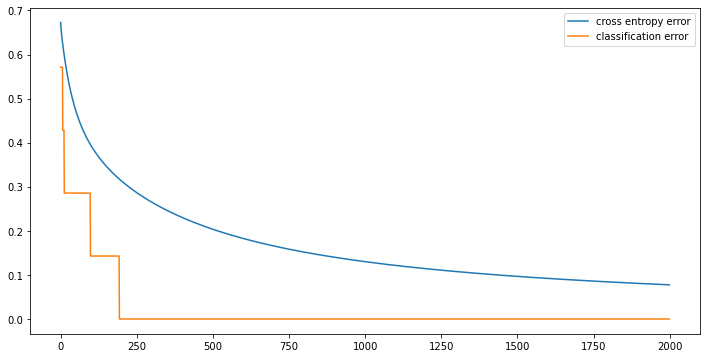

In [31]:
weights, trace = lr_train(seven_X, seven_y, trace=True)
ce_err, class_err = errors(seven_X, seven_y, trace)

plt.figure(figsize=(12,6))
plt.plot(range(len(trace)), ce_err, label='cross entropy error')
plt.plot(range(len(trace)), class_err, label='classification error')
plt.legend()

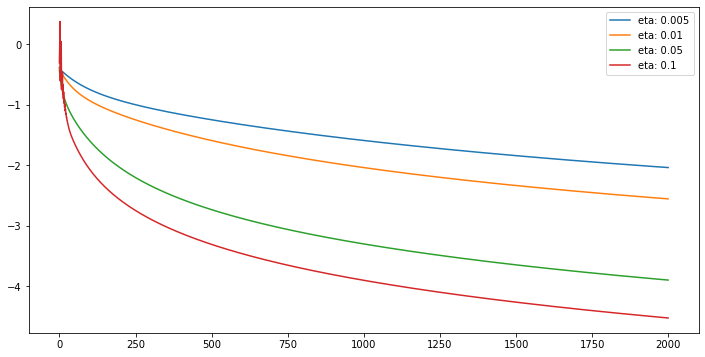

In [32]:
plt.figure(figsize=(12,6))

for eta in [0.005, 0.01, 0.05, 0.1]:
    error = []
    weights, trace = lr_train(seven_X, seven_y, trace=True, eta=eta)
    err = errors(seven_X, seven_y, trace)
    for e in err[0]:
        error.append(math.log(e))
    label = 'eta: ' + str(eta)
    plt.plot(range(len(trace)), error, label=label)
plt.legend()


**Q:** Zašto je pogreška unakrsne entropije veća od pogreške klasifikacije? Je li to uvijek slučaj kod logističke regresije i zašto?

**Q:** Koju stopu učenja $\eta$ biste odabrali i zašto?

### (e)

Upoznajte se s klasom [`linear_model.LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) koja implementira logističku regresiju. Usporedite rezultat modela na skupu `seven` s rezultatom koji dobivate pomoću vlastite implementacije algoritma.

**NB:** Kako ugrađena implementacija koristi naprednije verzije optimizacije funkcije, vrlo je vjerojatno da Vam se rješenja neće poklapati, ali generalne performanse modela bi trebale. Ponovno, pripazite na broj iteracija i snagu regularizacije.

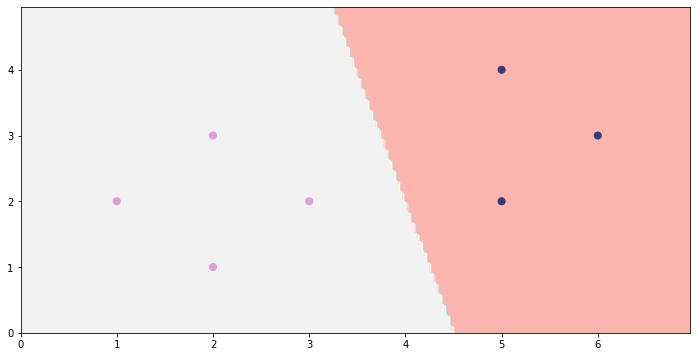

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
model = lr.fit(seven_X, seven_y)

plot_2d_clf_problem(seven_X, seven_y, model.predict)

### 2. Analiza logističke regresije

### (a)

Koristeći ugrađenu implementaciju logističke regresije, provjerite kako se logistička regresija nosi s vrijednostima koje odskaču. Iskoristite skup `outlier`. Prikažite granicu između klasa.

In [17]:
outlier_X = np.append(seven_X, [[12,8]], axis=0)
outlier_y = np.append(seven_y, 0)

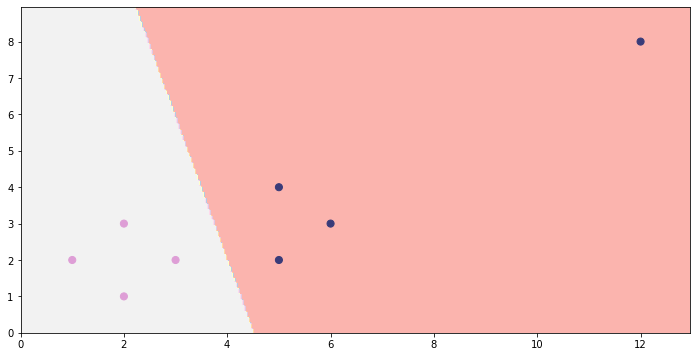

In [18]:
lr = LogisticRegression()
model = lr.fit(outlier_X, outlier_y)
plot_2d_clf_problem(outlier_X, outlier_y, model.predict)

**Q:** Zašto se rezultat razlikuje od onog koji je dobio model klasifikacije linearnom regresijom iz prvog zadatka?

### (b)

Trenirajte model logističke regresije na skupu `seven` te na dva odvojena grafikona prikažite, kroz iteracije optimizacijskoga algoritma, (1) izlaz modela $h(\mathbf{x})$ za svih sedam primjera te (2) vrijednosti težina $w_0$, $w_1$, $w_2$.

In [35]:
def analyse(X, y, iterations):
    w0 = []
    w1 = []
    w2 = []
    h = []
    weights, trace = lr_train(X, y, trace=True, max_iter=iterations)
    for t in trace:
        temp = []
        w0.append(t[0])
        w1.append(t[1])
        w2.append(t[2])
        for x in X:
            temp.append(lr_h(x, t))
        h.append(temp)
    
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 1, 1)
    h = np.array(h)
    
    for i in range(len(h[0])):
        plt.plot(range(iterations), h[:, i])
        
    plt.subplot(2, 1, 2)
    plt.plot(range(iterations), w0, label='w0')
    plt.plot(range(iterations), w1, label='w1')
    plt.plot(range(iterations), w2, label='w2')
    plt.legend()
    plt.show()
    

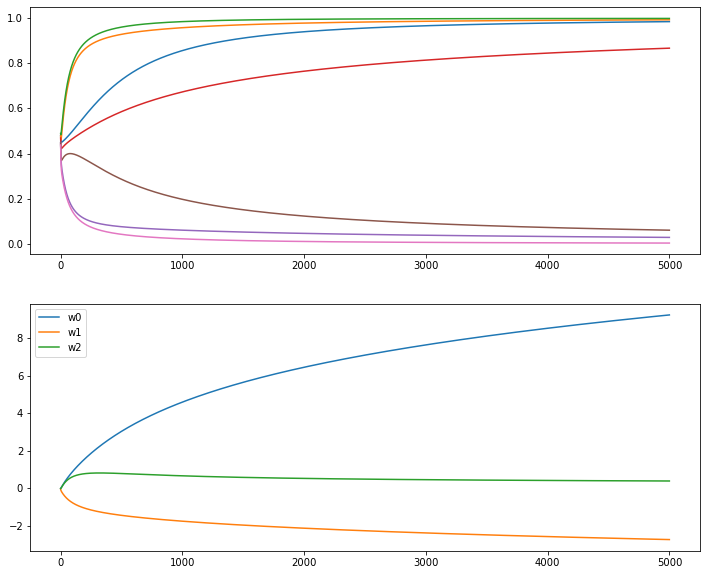

In [36]:
analyse(seven_X, seven_y, 5000)

### (c)

Ponovite eksperiment iz podzadatka (b) koristeći linearno neodvojiv skup podataka `unsep`.

In [21]:
unsep_X = np.append(seven_X, [[2,2]], axis=0)
unsep_y = np.append(seven_y, 0)

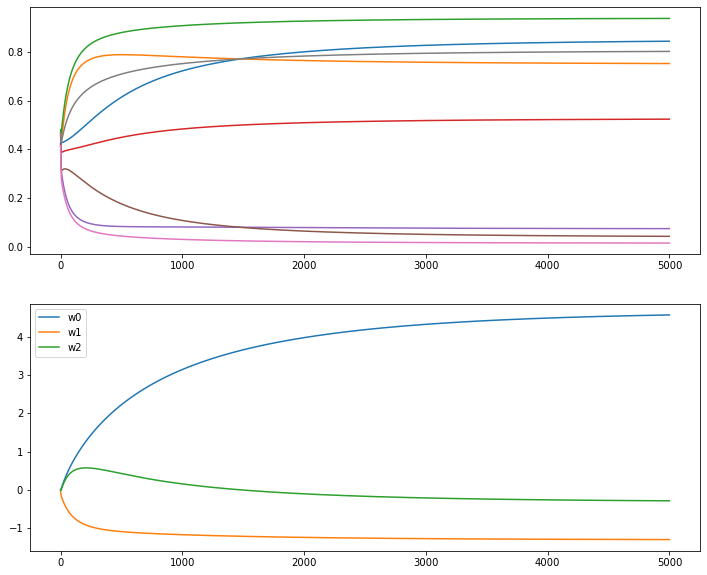

In [37]:
analyse(unsep_X, unsep_y, 5000)

**Q:** Usporedite grafikone za slučaj linearno odvojivih i linearno neodvojivih primjera te komentirajte razliku.

### 3. Regularizirana logistička regresija

Trenirajte model logističke regresije na skupu `seven` s različitim faktorima L2-regularizacije, $\alpha\in\{0,1,10,100\}$. Prikažite na dva odvojena grafikona (1) pogrešku unakrsne entropije te (2) L2-normu vektora $\mathbf{w}$ kroz iteracije optimizacijskog algoritma.

In [23]:
from numpy.linalg import norm

In [40]:
def reg_log_reg(alpha):
    plt.figure(figsize(20, 5))
    pltNum = 1
    for a in alpha:
        err = []
        norm2 = []
        weights, trace = lr_train(seven_X, seven_y, alpha=a, trace=True)
        for t in trace:
            err.append(cross_entropy_error(seven_X, seven_y, t))
            norm2.append(norm(t))
        plt.subplot(1, 2, 1)
        plt.plot(range(len(trace)), err, label='a: ' + str(a))
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(range(len(trace)), norm2, label='a: ' + str(a))
        plt.legend()
    plt.show()

<ipython-input-40-aae32579f1ce>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-40-aae32579f1ce>:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)
<ipython-input-40-aae32579f1ce>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created an

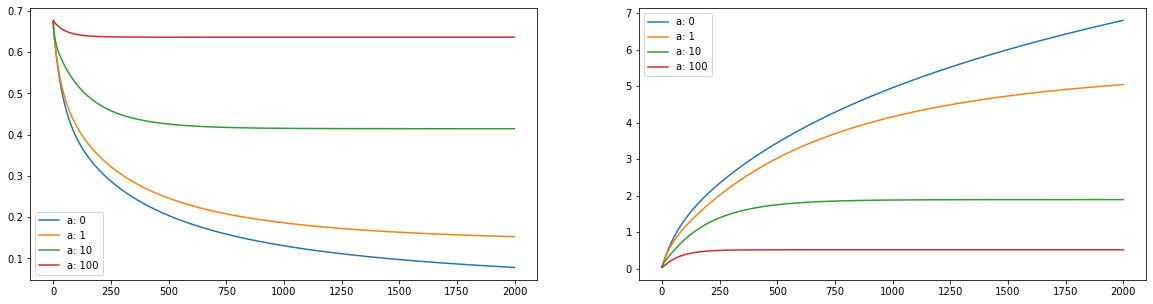

In [41]:
reg_log_reg([0, 1, 10, 100])

**Q:** Jesu li izgledi krivulja očekivani i zašto?

**Q:** Koju biste vrijednost za $\alpha$ odabrali i zašto?

### 4. Logistička regresija s funkcijom preslikavanja

Proučite funkciju [`datasets.make_classification`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). Generirajte i prikažite dvoklasan skup podataka s ukupno $N=100$ dvodimenzijskih ($n=2)$ primjera, i to sa dvije grupe po klasi (`n_clusters_per_class=2`). Malo je izgledno da će tako generiran skup biti linearno odvojiv, međutim to nije problem jer primjere možemo preslikati u višedimenzijski prostor značajki pomoću klase [`preprocessing.PolynomialFeatures`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html), kao što smo to učinili kod linearne regresije u prvoj laboratorijskoj vježbi. Trenirajte model logističke regresije koristeći za preslikavanje u prostor značajki polinomijalnu funkciju stupnja $d=2$ i stupnja $d=3$. Prikažite dobivene granice između klasa. Možete koristiti svoju implementaciju, ali se radi brzine preporuča koristiti `linear_model.LogisticRegression`. Regularizacijski faktor odaberite po želji.

**NB:** Kao i ranije, za prikaz granice između klasa koristite funkciju `plot_2d_clf_problem`. Funkciji kao argumente predajte izvorni skup podataka, a preslikavanje u prostor značajki napravite unutar poziva funkcije `h` koja čini predikciju, na sljedeći način:

In [26]:
from sklearn.preprocessing import PolynomialFeatures

#plot_2d_clf_problem(X, y, lambda x : model.predict(poly.transform(x))

In [45]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = 100,
                           n_classes = 2, 
                           n_clusters_per_class = 2,
                           n_features = 2,
                           n_redundant = 0)

In [46]:
def pol_feat(X, y, d, C):
    poly = PolynomialFeatures(d)
    phi = poly.fit_transform(X)
    h = LogisticRegression(C=C).fit(phi, y)
    plot_2d_clf_problem(X, y, lambda x : h.predict(poly.fit_transform(x)))
    plt.show()

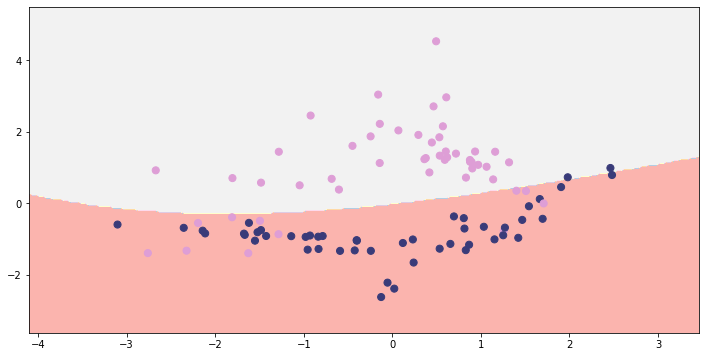

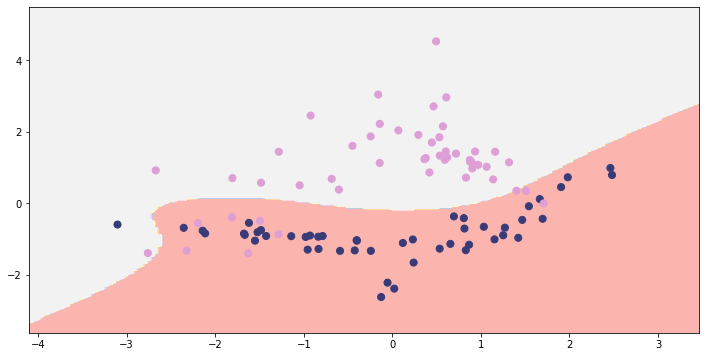

In [47]:
pol_feat(X, y, 2, 0.2)
pol_feat(X, y, 3, 0.2)

**Q:** Koji biste stupanj polinoma upotrijebili i zašto? Je li taj odabir povezan s odabirom regularizacijskog faktora $\alpha$? Zašto?